In [1]:
import os, pickle, warnings, itertools
from pathlib import Path
from functools import partial 

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)


%load_ext autoreload
%autoreload 1
%aimport salford_datasets.salford, salford_datasets.salford_raw, transformer_experiment.utils.embeddings, transformer_experiment.utils.finetuning, transformer_experiment.utils.shallow_classifiers, transformer_experiment.utils.plots
%aimport acd_experiment.base_dataset, acd_experiment.salford_adapter, acd_experiment.models, acd_experiment.sci, acd_experiment.systematic_comparison

from salford_datasets.salford import SalfordData, SalfordFeatures, SalfordPrettyPrint, SalfordCombinations
from acd_experiment.salford_adapter import SalfordAdapter

In [2]:
class Notebook:
    DATA_DIR = Path('data/Salford')
    CACHE_DIR = Path('data/cache')
    IMAGE_DIR = Path('images/shallow')
    SYSTEMATIC_COMPARISON_DIR = Path('data/systematic_comparison/')
    RE_DERIVE = False

In [3]:
from transformer_experiment.utils.shallow_classifiers import load_salford_dataset, get_train_test_indexes

SAL = load_salford_dataset(Notebook.RE_DERIVE, Notebook.DATA_DIR)
SAL_TRAIN_IDX, SAL_TEST_IDX, SAL_TEST_UNSEEN_IDX, SAL_TEST_IS_UNSEEN = get_train_test_indexes(SAL)

2023-04-09 21:38:05,099 [INFO] Loading processed dataset


In [4]:
from acd_experiment.models import Estimator_L1Regression, Estimator_LinearSVM, Estimator_LightGBM, Estimator_L2Regression, Estimator_ElasticNetRegression, Estimator_XGBoost

FEATURE_GROUP_CORRESPONDENCE = {
    'news': 'news',
    'with_phenotype': 'news_with_phenotype',
    'with_labs': 'with_labs',
    'with_services': 'with_notes_labs_and_hospital'
}

PRETTY_PRINT_FEATURE_GROUPS = {
    'Reference': 'Reference',
    'news': 'Vitals',
    'with_phenotype': '& Obs',
    'with_labs': '& Labs',
    'with_services': '& Services',
}

PRETTY_PRINT_ESTIMATORS = dict(
    NEWS2='NEWS2',
    LogisticRegression='LR',
    L1Regression='LR-L1',
    L2Regression='LR-L2',
    ElasticNetRegression='LR-EN',
    XGBoost='XGBoost',
    LightGBM='LightGBM',
    LinearSVM='LinearSVM'
)

PRETTY_PRINT_FEATURE_NAMES = {
    k:(
        v.replace('First Blood ', '')
        .replace('First Obs ', '')
        .replace('Emergency Department', 'ED')
    )
    for k,v in SalfordPrettyPrint.items()
}

ESTIMATORS = {_._name: _ for _ in [
    Estimator_LightGBM,
    Estimator_L2Regression,
    Estimator_XGBoost,
    Estimator_LinearSVM,
    Estimator_L1Regression,
    Estimator_ElasticNetRegression,
]}

STUDY_GRID = list(itertools.product(ESTIMATORS.keys(), FEATURE_GROUP_CORRESPONDENCE.keys()))

## Model Training

In [5]:
from acd_experiment.salford_adapter import SalfordAdapter
from sklearn.calibration import CalibratedClassifierCV
import optuna
from acd_experiment.systematic_comparison import get_xy, PipelineFactory

def run_pretuned(sal, estimator_name, feature_group_name, cv_jobs=4, explain_models=['LightGBM', 'L2Regression']):
    params = optuna.load_study(
        study_name =f'{estimator_name}_None_Within-1_{FEATURE_GROUP_CORRESPONDENCE[feature_group_name]}', storage=f'sqlite:///{Notebook.SYSTEMATIC_COMPARISON_DIR}/{estimator_name}.db'
    ).best_params
    
    estimator = ESTIMATORS[estimator_name]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X, y = SalfordAdapter(sal).xy(
            x=SalfordCombinations[feature_group_name],
            imputation = estimator._requirements['imputation'],
            fillna = estimator._requirements['fillna'],
            ordinal_encoding = estimator._requirements['ordinal'],
            onehot_encoding = estimator._requirements['onehot']
        )
    X_train, y_train = SalfordAdapter(X.loc[SAL_TRAIN_IDX]), y.loc[SAL_TRAIN_IDX].values

    pipeline_factory = PipelineFactory(
        estimator=estimator, resampler=None, X_train=X_train, y_train=y_train,
    )

    model = CalibratedClassifierCV(
        pipeline_factory(**params), cv=cv_jobs, method="isotonic", n_jobs=cv_jobs,
    ).fit(X_train, y_train)


    y_pred_proba = model.predict_proba(X.loc[SAL_TEST_IDX])[:,1]
    y_pred_proba_unseen = y_pred_proba[SAL_TEST_IS_UNSEEN]

    explanations = None
    if estimator_name in explain_models:
        explanations = estimator.explain_calibrated(
            model, X_train, SalfordAdapter(X.loc[SAL_TEST_IDX]), cv_jobs=cv_jobs
        )

        return y_pred_proba, y_pred_proba_unseen, explanations, model
    
    return y_pred_proba, y_pred_proba_unseen

if Notebook.RE_DERIVE:
    RESULTS = {}
    for estimator_name, feature_group_name in (pbar := tqdm(STUDY_GRID)):
        pbar.set_description(f'Training {estimator_name} on {feature_group_name}')
        RESULTS[(estimator_name, feature_group_name)] = run_pretuned(SAL, estimator_name, feature_group_name)

        with open(Notebook.CACHE_DIR/'shallow_results_2.bin', 'wb') as file:
            pickle.dump(RESULTS, file)
else:
    with open(Notebook.CACHE_DIR/'shallow_results_2.bin', 'rb') as file:
            RESULTS = pickle.load(file)

In [13]:
from transformer_experiment.utils.shallow_classifiers import get_discriminative_metrics
Y_TRUES = {
    'Complete': SAL.CriticalEvent.loc[SAL_TEST_IDX],
    'Unseen': SAL.CriticalEvent.loc[SAL_TEST_UNSEEN_IDX],
}
def get_full_metrics_tables(results):
    metrics = {
        'Complete': [],
        'Unseen': [],
    }
    for (estimator_name, feature_group_name), y_preds in results.items():
        for y_pred_proba, (y_true_name, y_true) in zip(y_preds, Y_TRUES.items()):

            metrics[y_true_name].append(dict(
                Estimator = estimator_name,
                Features = feature_group_name,
            ) | get_discriminative_metrics(
                y_true, y_pred_proba
            ))
    
    for y_true_name, y_true in Y_TRUES.items():
        metrics[y_true_name].append(dict(
            Estimator='NEWS2',
            Features='Reference'
        ) | get_discriminative_metrics(
            y_true, SAL.NEWS_Score_Admission.loc[y_true.index]
        ))

    return {
        y_true_name: pd.DataFrame(metric_list) for y_true_name, metric_list in metrics.items()
    }

METRICS = get_full_metrics_tables(RESULTS)

## Metrics

### Summary Table

In [30]:
def summary_metrics_select_estimators(metrics, estimators=['LightGBM', 'LR-L2']):
    df = pd.DataFrame(dict(
            Metric=metric,
            Estimator=_['Estimator'],
            Features=PRETTY_PRINT_FEATURE_GROUPS[_['Features']],
            Value=f"{_[metric]:.3f}",
            Dataset=dataset
        ) for dataset, df in metrics.items() for _ in df[df.Estimator.isin(estimators)].to_dict(orient='records') for metric in ('AUROC', 'AP')
    ).sort_values(['Metric', 'Estimator', 'Dataset']).set_index(['Metric', 'Estimator', 'Dataset', 'Features']).unstack()['Value'][list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]]
    return df

result_metrics_summary = summary_metrics_select_estimators(METRICS)
result_metrics_summary

Features                  Vitals  & Obs & Labs & Services
Metric Estimator Dataset                                 
AP     LR-L2     Complete  0.140  0.248  0.274      0.345
                 Unseen    0.176  0.304  0.327      0.408
       LightGBM  Complete  0.241  0.392  0.468      0.499
                 Unseen    0.301  0.462  0.545      0.577
AUROC  LR-L2     Complete  0.710  0.816  0.835      0.855
                 Unseen    0.709  0.820  0.840      0.862
       LightGBM  Complete  0.794  0.877  0.908      0.915
                 Unseen    0.802  0.886  0.917      0.925

In [17]:
#print(result_metrics_summary.to_latex(bold_rows=True, escape=False, column_format='lll|cccc', multirow=True, formatters=[lambda x: f'${x}$' for _ in range(result_metrics_summary.shape[1])]))

### Detailed Tables

In [14]:
def detailed_metrics_all_estimators(metrics):
    df = pd.DataFrame(dict(
            Dataset=dataset,
            Metric=metric,
            Estimator=_['Estimator'],
            Features=PRETTY_PRINT_FEATURE_GROUPS[_['Features']],
            Summary = f'{_[metric]:.4f} ({_[metric+"_Lower"]:.4f}-{_[metric + "_Upper"]:.4f})'
        ) for dataset, df in metrics.items() for _ in df.to_dict(orient='records') for metric in ('AUROC', 'AP')
    ).pivot(index=['Features', 'Estimator'], columns=['Metric', 'Dataset'], values='Summary')

    return df.loc[PRETTY_PRINT_FEATURE_GROUPS.values()][['AUROC', 'AP']]

result_metrics_long = detailed_metrics_all_estimators(METRICS)
result_metrics_long

Metric                                            AUROC  \
Dataset                                        Complete   
Features   Estimator                                      
Reference  NEWS2                 0.7340 (0.7213-0.7471)   
Vitals     ElasticNetRegression  0.7093 (0.6953-0.7198)   
           L1Regression          0.7088 (0.6947-0.7192)   
           L2Regression          0.7099 (0.6959-0.7200)   
           LightGBM              0.7942 (0.7821-0.8080)   
           LinearSVM             0.7512 (0.7397-0.7656)   
           XGBoost               0.7953 (0.7842-0.8083)   
& Obs      ElasticNetRegression  0.8166 (0.8054-0.8237)   
           L1Regression          0.8159 (0.8044-0.8235)   
           L2Regression          0.8158 (0.8046-0.8234)   
           LightGBM              0.8773 (0.8690-0.8830)   
           LinearSVM             0.8099 (0.7987-0.8187)   
           XGBoost               0.8753 (0.8684-0.8809)   
& Labs     ElasticNetRegression  0.8363 (0.8260-0.8445)   
           L1Regression          0.8375 (0.8277-0.8458)   
           L2Regression          0.8354 (0.8252-0.8439)   
           LightGBM              0.9079 (0.9018-0.9129)   
           LinearSVM             0.8361 (0.8261-0.8433)   
           XGBoost               0.9076 (0.9003-0.9126)   
& Services ElasticNetRegression  0.8556 (0.8459-0.8632)   
           L1Regression          0.8552 (0.8458-0.8629)   
           L2Regression          0.8548 (0.8454-0.8625)   
           LightGBM              0.9150 (0.9087-0.9200)   
           LinearSVM             0.8514 (0.8418-0.8592)   
           XGBoost               0.9125 (0.9063-0.9175)   

Metric                                                   \
Dataset                                          Unseen   
Features   Estimator                                      
Reference  NEWS2                 0.7372 (0.7199-0.7496)   
Vitals     ElasticNetRegression  0.7083 (0.6931-0.7231)   
           L1Regression          0.7078 (0.6928-0.7218)   
           L2Regression          0.7092 (0.6938-0.7238)   
           LightGBM              0.8021 (0.7879-0.8146)   
           LinearSVM             0.7541 (0.7354-0.7678)   
           XGBoost               0.8037 (0.7886-0.8163)   
& Obs      ElasticNetRegression  0.8212 (0.8125-0.8310)   
           L1Regression          0.8218 (0.8130-0.8312)   
           L2Regression          0.8198 (0.8109-0.8298)   
           LightGBM              0.8857 (0.8761-0.8947)   
           LinearSVM             0.8154 (0.8049-0.8249)   
           XGBoost               0.8835 (0.8763-0.8910)   
& Labs     ElasticNetRegression  0.8410 (0.8315-0.8492)   
           L1Regression          0.8436 (0.8342-0.8516)   
           L2Regression          0.8398 (0.8301-0.8481)   
           LightGBM              0.9168 (0.9100-0.9249)   
           LinearSVM             0.8398 (0.8278-0.8483)   
           XGBoost               0.9171 (0.9098-0.9252)   
& Services ElasticNetRegression  0.8624 (0.8540-0.8707)   
           L1Regression          0.8622 (0.8539-0.8707)   
           L2Regression          0.8616 (0.8532-0.8703)   
           LightGBM              0.9249 (0.9180-0.9331)   
           LinearSVM             0.8581 (0.8482-0.8664)   
           XGBoost               0.9226 (0.9164-0.9303)   

Metric                                               AP  \
Dataset                                        Complete   
Features   Estimator                                      
Reference  NEWS2                 0.1400 (0.1301-0.1537)   
Vitals     ElasticNetRegression  0.1383 (0.1261-0.1540)   
           L1Regression          0.1396 (0.1273-0.1552)   
           L2Regression          0.1397 (0.1270-0.1543)   
           LightGBM              0.2413 (0.2211-0.2587)   
           LinearSVM             0.1528 (0.1400-0.1684)   
           XGBoost               0.2433 (0.2207-0.2629)   
& Obs      ElasticNetRegression  0.2425 (0.2184-0.2642)   
           L1Regression          0.2364 (0.21

In [21]:
def metrics_delta_comparison(metrics):
    print(f"AUROC: {(metrics['Complete']['AUROC'] - metrics['Unseen']['AUROC']).median()}")
    print(f"AP: {(metrics['Complete']['AP'] - metrics['Unseen']['AP']).median()}")

metrics_delta_comparison(METRICS)

AUROC: -0.006071509850782308
AP: -0.05953399776656826


In [23]:
#print(result_metrics_long.to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='llrrrr'))

### NEWS Comparison

In [24]:
from transformer_experiment.utils.shallow_classifiers import get_decision_metrics, get_decision_threshold
from sklearn.metrics import recall_score

def news_threshold_comparison(y_preds, estimators=['LightGBM', 'L2Regression'], news_thresholds=[3, 5, 7], confidence_intervals=True):
    y_true = Y_TRUES['Complete']
    news_values = SAL.loc[y_true.index].NEWS_Score_Admission
    news_sensitivities = {
        threshold: recall_score(y_true, news_values >= threshold) 
        for threshold in news_thresholds
    }

    results = [
        dict(
            Estimator="NEWS",
            Features=None,
            Threshold=f'$\geq {news_threshold}$',
        ) | get_decision_metrics(y_true, news_values >= news_threshold, confidence_intervals) 
        for news_threshold in news_sensitivities.keys()
    ]

    for estimator in estimators:
        for feature_group, feature_group_name in PRETTY_PRINT_FEATURE_GROUPS.items():
            if feature_group == 'Reference':
                continue
            y_pred_proba = y_preds[(estimator, feature_group)][0]
            for news_threshold, observed_sensitivity in news_sensitivities.items():
                threshold = get_decision_threshold(y_true, y_pred_proba, target_recall=observed_sensitivity)
                y_pred = np.where(y_pred_proba > threshold, 1, 0)
                results.append(dict(
                    Estimator=estimator,
                    Features=feature_group_name,
                    Threshold=f'$\geq {news_threshold}$',
                ) | get_decision_metrics(y_true, y_pred, confidence_intervals))

    return pd.DataFrame(results).set_index(['Estimator', 'Features'])#[list(r.columns[-1:]) + list(r.columns[:-1])]

result_news_comparison = news_threshold_comparison(RESULTS, confidence_intervals=False)
result_news_comparison

Threshold  Sensitivity  Specificity       PPV  \
Estimator    Features                                                   
NEWS         NaN         $\geq 3$     0.741276     0.791388  0.071148   
             NaN         $\geq 5$     0.475331     0.934319  0.134950   
             NaN         $\geq 7$     0.259928     0.979559  0.215139   
LightGBM     Vitals      $\geq 3$     0.741276     0.796835  0.072917   
             Vitals      $\geq 5$     0.475331     0.933671  0.133808   
             Vitals      $\geq 7$     0.259928     0.977276  0.197802   
             & Obs       $\geq 3$     0.741276     0.812659  0.078591   
             & Obs       $\geq 5$     0.475331     0.955512  0.187204   
             & Obs       $\geq 7$     0.257521     0.988586  0.327217   
             & Scores    $\geq 3$     0.741276     0.837173  0.089366   
             & Scores    $\geq 5$     0.475331     0.961738  0.211230   
             & Scores    $\geq 7$     0.259928     0.989624  0.350649   
             & Labs      $\geq 3$     0.741276     0.887938  0.124797   
             & Labs      $\geq 5$     0.475331     0.970065  0.255003   
             & Labs      $\geq 7$     0.259928     0.991102  0.386404   
             & Services  $\geq 3$     0.741276     0.896109  0.133304   
             & Services  $\geq 5$     0.475331     0.975642  0.296102   
             & Services  $\geq 7$     0.258724     0.994371  0.497685   
L2Regression Vitals      $\geq 3$     0.741276     0.755564  0.061361   
             Vitals      $\geq 5$     0.472924     0.896576  0.089726   
             Vitals      $\geq 7$     0.258724     0.967315  0.145763   
             & Obs       $\geq 3$     0.738869     0.752270  0.060409   
             & Obs       $\geq 5$     0.475331     0.921193  0.115060   
             & Obs       $\geq 7$     0.258724     0.982879  0.245714   
             & Scores    $\geq 3$     0.741276     0.768846  0.064658   
             & Scores    $\geq 5$     0.471721     0.927782  0.123426   
             & Scores    $\geq 7$     0.262335     0.981634  0.235421   
             & Labs      $\geq 3$     0.741276     0.801660  0.074558   
             & Labs      $\geq 5$     0.475331     0.946589  0.160962   
             & Labs      $\geq 7$     0.259928     0.987626  0.311688   
             & Services  $\geq 3$     0.741276     0.827030  0.084569   
             & Services  $\geq 5$     0.475331     0.961764  0.211343   
             & Services  $\geq 7$     0.259928     0.990506  0.371134   

                              NPV  Accuracy        F2        NNE  
Estimator    Features                                             
NEWS         NaN         0.993002  0.790330  0.257052  14.055195  
             NaN         0.988040  0.924634  0.315949   7.410127  
             NaN         0.983975  0.964374  0.249538   4.648148  
LightGBM     Vitals      0.993049  0.795663  0.261638  13.714286  
             Vitals      0.988032  0.923999  0.314691   7.473418  
             Vitals      0.983938  0.962139  0.244565   5.055556  
             & Obs       0.993184  0.811153  0.275936  12.724026  
             & Obs       0.988302  0.945380  0.363452   5.341772  
             & Obs       0.984068  0.973160  0.268979   3.056075  
             & Scores    0.993382  0.835149  0.301458  11.189935  
             & Scores    0.988377  0.951474  0.380246   4.734177  
             & Scores    0.984135  0.974226  0.274112   2.851852  
             & Labs      0.993758  0.884843  0.372881   8.012987  
             & Labs      0.988475  0.959625  0.405294   3.921519  
             & Labs      0.984158  0.975674  0.278135   2.587963  
             & Services  0.993815  0.892842  0.387665   7.501623  
             & Services  0.988540  0.965085  0.424002   3.377215  
             & Services  0.984184  0.978848  0.286209   2.009302  
L2Regression Vitals      0.992673  0.755263  0.230487  16.297078  
             Vitals      0.987486  0.887636  0.255062  11.145

## Bar Plots

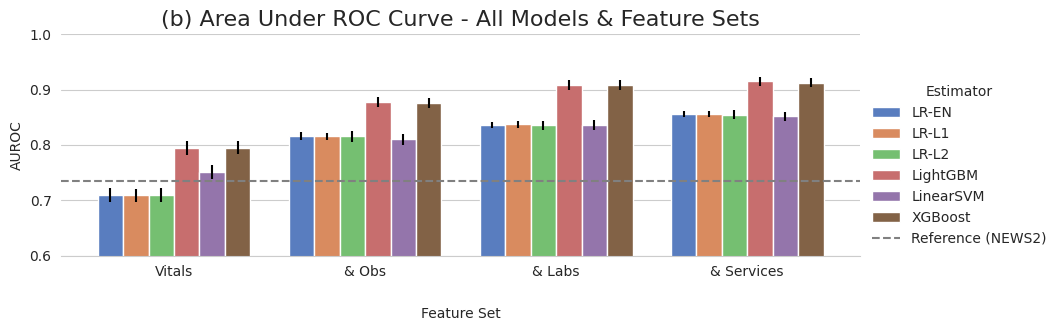

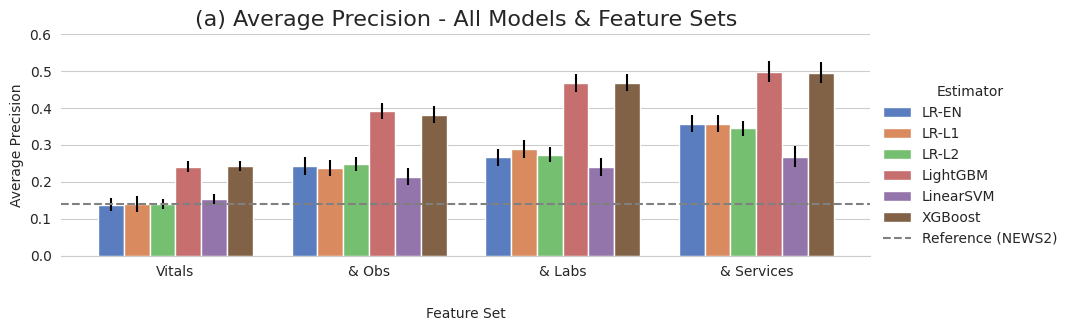

In [32]:
def select_feature_ablation_barplot(metrics_df, metric='AUROC', ylim=(0.0, 1.0), ylabel=None, title=None, save=None):
    sns.set_style('whitegrid')
    df = metrics_df[metrics_df.Estimator != 'NEWS2'].copy()
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = pd.Categorical(
        df.Features.replace(PRETTY_PRINT_FEATURE_GROUPS), 
        ordered=True, categories=list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]
    )

    g = sns.catplot(
        data=df.sort_values(['Estimator','Features']), x='Features', y=metric, hue='Estimator',
        kind='bar', palette='muted', height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(9,3)
    g.ax.set_ylim(ylim)

    x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    y_coords = [p.get_height() for p in g.ax.patches]
    g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    news_performance = metrics_df.loc[metrics_df.Estimator == 'NEWS2', metric].values[0]

    g.refline(y = news_performance , color = 'gray', linestyle = '--', label = "Reference (NEWS2)") 
    g.add_legend(title='Estimator')
    
    g.set_xlabels("Feature Set", labelpad=20)
    g.ax.set_title(title, fontsize=16)
    
    if ylabel:
        g.set_ylabels(ylabel)

    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

select_feature_ablation_barplot(METRICS['Complete'], 'AUROC', (0.6, 1.0), ylabel='AUROC', title='(b) Area Under ROC Curve - All Models & Feature Sets', save=Notebook.IMAGE_DIR/'auc_bar.svg')
select_feature_ablation_barplot(METRICS['Complete'], 'AP', (0.0, 0.6), ylabel='Average Precision', title='(a) Average Precision - All Models & Feature Sets', save=Notebook.IMAGE_DIR/'ap_bar.svg')

## Calibration Curves

In [33]:
def estimator_y_preds_across_feature_groups(y_preds, estimator_target='LightGBM'):
    return {
        PRETTY_PRINT_FEATURE_GROUPS[feature_group]: y_pred_proba 
        for (estimator, feature_group), (y_pred_proba, *_) in y_preds.items()
        if estimator == estimator_target
    }

def feature_group_y_preds_across_estimators(y_preds, feature_group_target='with_services'):
    return {
        estimator: y_pred_proba
        for (estimator, feature_group), (y_pred_proba, *_) in y_preds.items()
        if feature_group == feature_group_target
    }

In [37]:
estimator_y_preds_across_feature_groups(RESULTS, 'XGBoost').keys()

dict_keys(['Vitals', '& Obs', '& Labs', '& Services'])

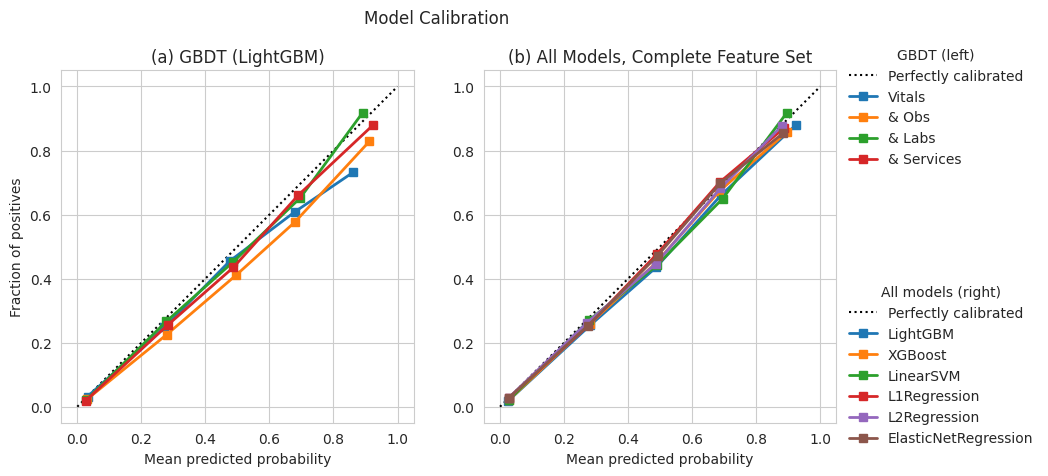

In [43]:
from transformer_experiment.utils.plots import plot_calibration_curves

def calib_curves(y_preds, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    y_true = Y_TRUES['Complete']
    y_preds_l, y_preds_r = (
        estimator_y_preds_across_feature_groups(y_preds, 'LightGBM'), 
        feature_group_y_preds_across_estimators(y_preds, 'with_services')
    )
    y_preds_r['LinearSVM'] = estimator_y_preds_across_feature_groups(y_preds, 'XGBoost')['& Labs']

    plot_calibration_curves(y_true, y_preds_l, ax=ax[0], title='(a) GBDT (LightGBM)')
    plot_calibration_curves(y_true, y_preds_r, ax=ax[1], title='(b) All Models, Complete Feature Set')

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
   
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Model Calibration')
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
   

calib_curves(RESULTS, save=Notebook.IMAGE_DIR/'calib_curves.svg')

## Alert Rate & PR

In [44]:
TEST_SET_N_DAYS = (
    SAL.loc[SAL_TEST_IDX].AdmissionDate.max() - SAL.loc[SAL_TEST_IDX].AdmissionDate.min()
).days
TEST_SET_N_DAYS

1010

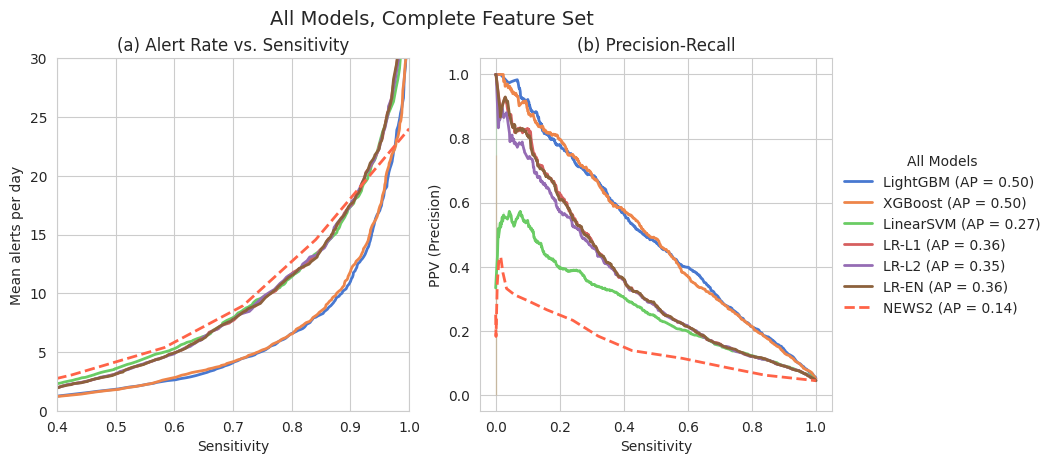

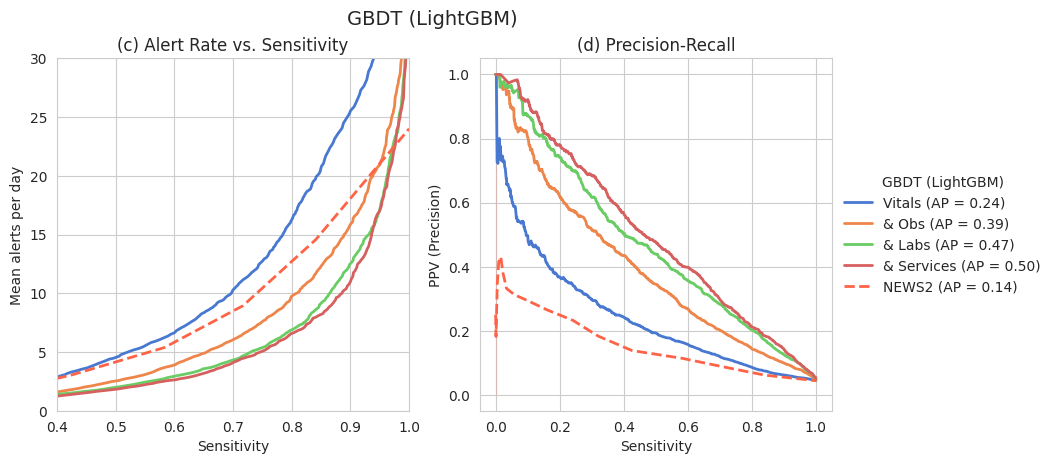

In [51]:
from transformer_experiment.utils.plots import plot_pr_curves, plot_alert_rate

def pr_and_alertrate_curves_estimator(y_preds, estimator, title, legend_label, subtitle_lettering, save=None):
    y_preds = estimator_y_preds_across_feature_groups(y_preds, estimator)   
    return pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save)

def pr_and_alertrate_curves_feature_group(y_preds, feature_group, title, legend_label, subtitle_lettering, save=None):
    y_preds = feature_group_y_preds_across_estimators(y_preds, feature_group)
    y_preds = {
        PRETTY_PRINT_ESTIMATORS[estimator]: y for estimator, y in y_preds.items()
    }
    return pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save)

def pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': SAL.loc[y_true.index].NEWS_Score_Admission}
    
    with sns.color_palette('muted'):
        plot_alert_rate(
            y_true, y_preds | baseline_news, TEST_SET_N_DAYS,
            ax=ax[0], intercepts=False, baseline_key='NEWS2', 
            title=f'{subtitle_lettering[0]} Alert Rate vs. Sensitivity', xlim=(0.4, 1.0), ylim=(0, 30)
        )

        plot_pr_curves(
            y_true, y_preds | baseline_news, 
            smoothing=True, ax=ax[1], 
            palette=sns.color_palette('muted'), 
            baseline_key='NEWS2', 
            title=f'{subtitle_lettering[1]} Precision-Recall'
        )
        
    sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5), frameon=False, title=legend_label)
    ax[0].legend([], [], frameon=False)
    
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title, fontsize=14)

    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

pr_and_alertrate_curves_feature_group(
    RESULTS, 'with_services',
    title='All Models, Complete Feature Set', legend_label='All Models', 
    subtitle_lettering=['(a)', '(b)'],
    save=Notebook.IMAGE_DIR/'alert_pr_all.svg'
)
pr_and_alertrate_curves_estimator(
    RESULTS, 'LightGBM', 
    title='GBDT (LightGBM)', legend_label='GBDT (LightGBM)', 
    subtitle_lettering=['(c)', '(d)'],
    save=Notebook.IMAGE_DIR/'alert_pr_lightgbm.svg'
)

### Intercepts

At sensitivity ~0.841: NEWS Alert rate: 14.574, LGBM Alert rate: 7.974 -> 45.285% less


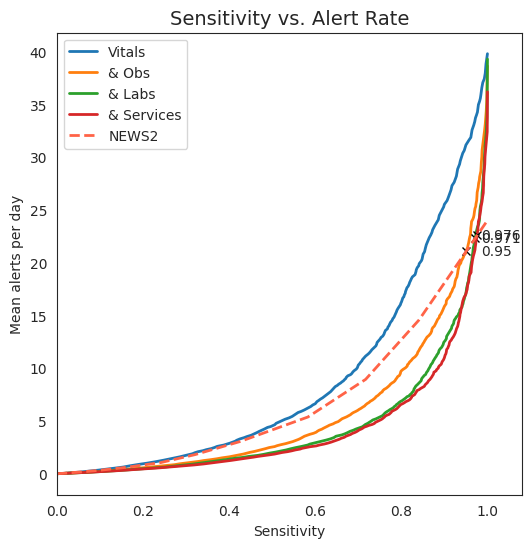

In [46]:
from transformer_experiment.utils.plots import plot_alert_rate, biggest_alert_rate_diff

def plot_alert_rate_with_intercepts(y_preds, estimator='LightGBM'):
    y_preds = estimator_y_preds_across_feature_groups(y_preds, estimator)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': SAL.loc[y_true.index].NEWS_Score_Admission}

    plot_alert_rate(
        y_true, y_preds | baseline_news, TEST_SET_N_DAYS,
        intercepts=True, baseline_key='NEWS2', 
    )

    sensitivity, news_rate, lgbm_rate = biggest_alert_rate_diff(
        y_true, baseline_news['NEWS2'], y_preds['& Services'], TEST_SET_N_DAYS,
    )

    print(
        f"At sensitivity ~{sensitivity:.3f}: NEWS Alert rate: {news_rate:.3f}, LGBM Alert rate: {lgbm_rate:.3f} -> {100-(lgbm_rate*100/news_rate):.3f}% less"
    )


plot_alert_rate_with_intercepts(RESULTS)

## SHAP

### Beeswarm Plot

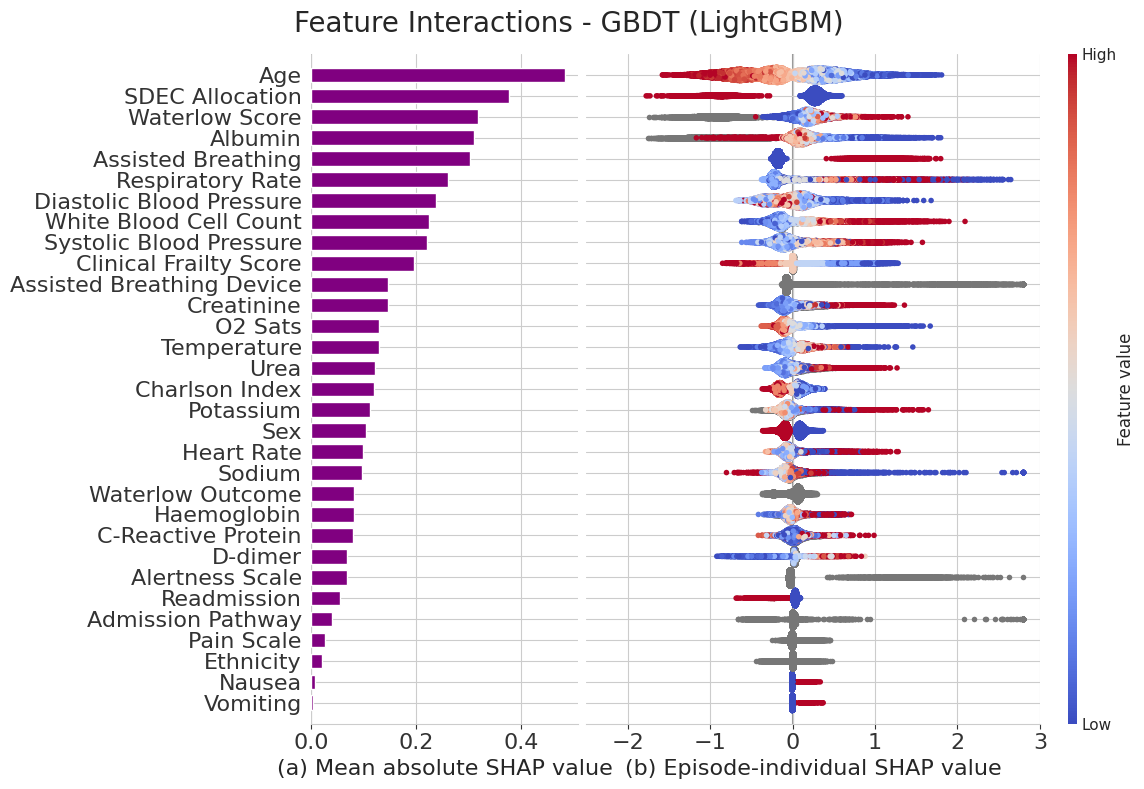

In [59]:
from transformer_experiment.utils.plots import plot_shap_features_joint

def lgbm_shap_beeswarm(y_preds, title='Feature Interactions - GBDT (LightGBM)', save=None):
    explanations = y_preds[('LightGBM', 'with_services')][-1]
    explanations.values[explanations.values >= 2.8] = 2.8
    plot_shap_features_joint(
        explanations, 
        max_display=250,
        figsize=(12, 8),
        wspace=-0.25,
        bar_aspect=0.04,
        topadjust=0.925,
        title=title,
        save=save
    )

lgbm_shap_beeswarm(RESULTS, save=Notebook.IMAGE_DIR/'shap_lgbm.png')

### Categorical Features

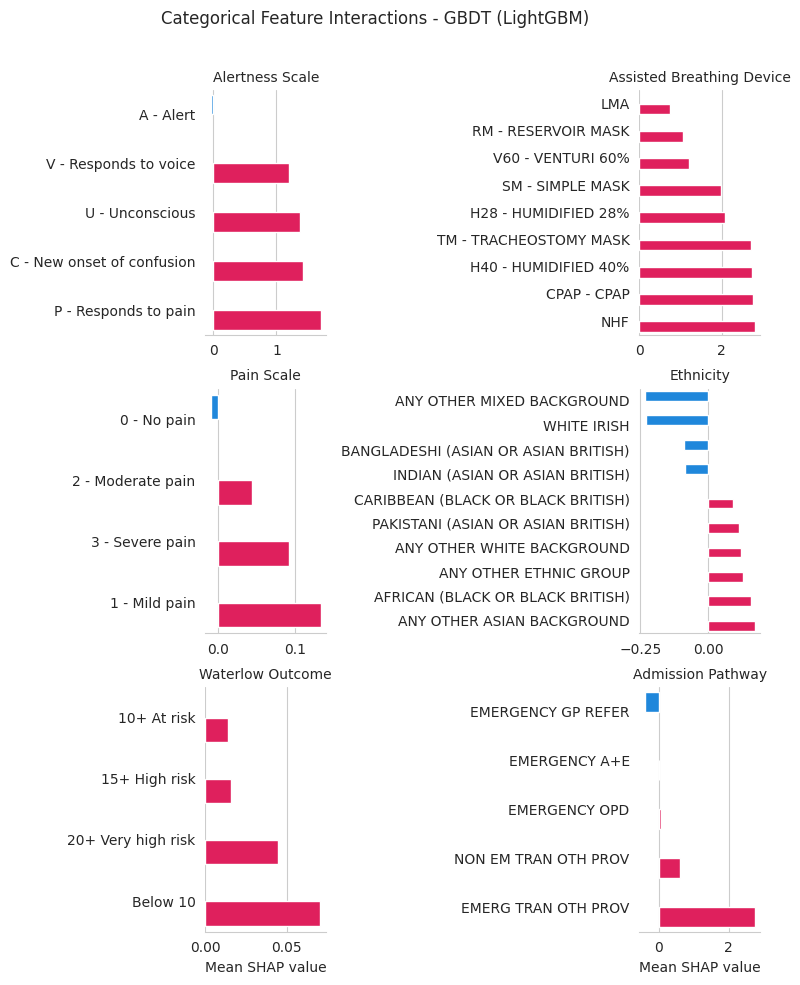

In [53]:
import shap
def categorical_shap_bars_lgbm(y_preds, save=None):
    explanations = y_preds[('LightGBM', 'with_services')][-1]
    
    r = []
    for column in SAL.categorical_columns(SalfordCombinations['with_services']):
        idx = explanations.feature_names.index(PRETTY_PRINT_FEATURE_NAMES[column])
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(10).index
        r.append(df.mean().loc[selected].sort_values().rename('SHAP').to_frame().assign(Feature=PRETTY_PRINT_FEATURE_NAMES[column]))

    df = pd.concat(r).reset_index()

    #df['Data'] = df['Data'].replace(pretty_print_categoricals)
    #df['Feature'] = df['Feature'].replace({'A&E Diagnosis': 'ED Diagnosis'})
    df['Hue'] = (df.SHAP > 0).astype(int)
    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df, x='SHAP', y='Data', col='Feature', hue='Hue', palette=[shap.plots.colors.blue_rgb, shap.plots.colors.red_rgb],
        kind='bar', orient='h', sharey=False, sharex=False, legend=False, col_wrap=2, 
        #col_order=['ED Diagnosis', 'Admission Specialty', 'Breathing Device', 'Admission Pathway', 'Presenting Complaint']
    )
    g.set_titles(template='{col_name}')
    g.fig.set_size_inches(8,10)
    g.fig.tight_layout()
    g.set_ylabels('')
    g.set_xlabels('Mean SHAP value')
    g.despine(left=True)
    g.fig.suptitle('Categorical Feature Interactions - GBDT (LightGBM)')
    g.fig.subplots_adjust(top=0.9)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

categorical_shap_bars_lgbm(RESULTS, Notebook.IMAGE_DIR/'shap_categorical.svg')

### Scatter Plots

In [ ]:
def comparison_scatter_plots(feature='Age', models=['LightGBM', 'L2Regression'], directory=Notebook.SYS_RESULTS_DIR, letters='ab', title=None, save=None):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    for i, model in enumerate(models):
        explanations = load_filtered_explanations(f'{model}_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
        
        explanations = explanations[:,explanations.feature_names.index(feature)]
        df = pd.concat([pd.Series(explanations.values, name='Value'), pd.Series(explanations.data, name=feature)], axis=1)
        if feature == 'Temperature':
            df = df[df.Temperature > 34]

        df['Colour'] = df.Value.apply(lambda x: x < 0)
        sns.scatterplot(data=df, x=feature, y='Value', hue='Colour', ax=ax[i], legend=False, palette=[shap.plots.colors.red_rgb, shap.plots.colors.blue_rgb], linewidth=0, s=16)
        ax[i].set_title(f'({letters[i]}) {pretty_print_models[model]}')
        points = ax[i].collections[0]
        points.set_rasterized(True)

    ax[0].set_ylabel(f'SHAP value for \n {feature}')
    ax[1].set_ylabel('')

    if not title:
        title = f'Patient-individual SHAP values for {feature}'
    fig.suptitle(title)

    if save:
        fig.savefig(save, bbox_inches='tight', format='svg')

comparison_scatter_plots(save=f'{Notebook.IMAGE_DIR}/shap_scatter_age.svg')

## Bias

### Entropy Curves

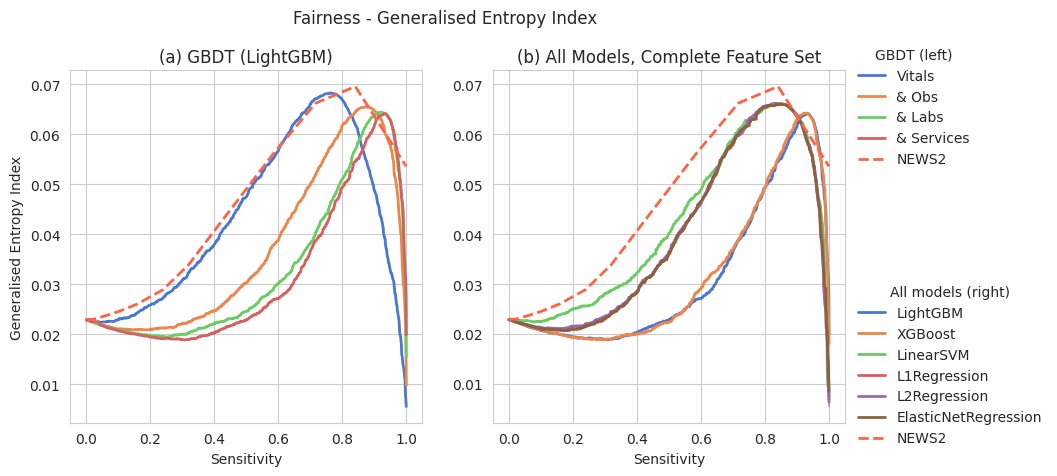

In [55]:
from transformer_experiment.utils.plots import plot_entropy_curves
from aif360.sklearn.metrics import generalized_entropy_error, between_group_generalized_entropy_error

def entropy_comparison(y_preds, prot_attr=None, save=None, function=generalized_entropy_error, title='Fairness - Generalised Entropy Index'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': SAL.loc[y_true.index].NEWS_Score_Admission}

    y_preds_l, y_preds_r = (
        estimator_y_preds_across_feature_groups(y_preds, 'LightGBM') | baseline_news, 
        feature_group_y_preds_across_estimators(y_preds, 'with_services') | baseline_news
    )

    plot_entropy_curves(
        y_true, y_preds_l, 
        function=function, prot_attr=prot_attr,
        ax=ax[0], title='(a) GBDT (LightGBM)', 
        baseline_key='NEWS2', palette=sns.color_palette('muted')
    )
    plot_entropy_curves(
        y_true, y_preds_r, 
        function=function, prot_attr=prot_attr,
        ax=ax[1], title='(b) All Models, Complete Feature Set', 
        baseline_key='NEWS2', palette=sns.color_palette('muted')
    )

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

entropy_comparison(RESULTS, save=Notebook.IMAGE_DIR/'entropy.svg') 


In [20]:
# entropy_comparison(
#     RESULTS, 
#     function=between_group_generalized_entropy_error, 
#     prot_attr=(
#         SAL.loc[SAL_TEST_IDX].CriticalEvent.set_axis(
#             SAL.loc[SAL_TEST_IDX, ['Female', 'Ethnicity']]
#         ).index), 
#     save=Notebook.IMAGE_DIR/'entropy_between.svg', 
#     title='Between-Group Fairness - Generalised Entropy Index'
# )

### Bias Amplification

In [66]:
from transformer_experiment.utils.shallow_classifiers import bootstrap_bias_amplification

def calculate_bias_amplifications(y_preds):
    X = SAL.loc[SAL_TEST_IDX]
    y_true = Y_TRUES['Complete']

    prot_attrs = dict(
        Sex=X.Female,
        Ethnicity=X.Ethnicity.fillna("NAN"),
        Both=y_true.set_axis(X[['Female', 'Ethnicity']].fillna("NAN")).index,
    )
  

    get_dict = lambda low, mid, high: dict(
        Bias_Amp = mid,
        Bias_Amp_Lower = low,
        Bias_Amp_Upper = high
    )

    df = pd.DataFrame(dict(
        Estimator=PRETTY_PRINT_ESTIMATORS[estimator],
        Features=PRETTY_PRINT_FEATURE_GROUPS[features],
        Protected=attr_key
    ) | get_dict(*bootstrap_bias_amplification(
        y_true, y_pred_proba, prot_attr, n_resamples=9
    )) for (estimator, features), (y_pred_proba, *_) in y_preds.items()
        for attr_key, prot_attr in prot_attrs.items()
    )

    df['Bias'] = df.Bias_Amp.map('{:.3f}'.format) + ' (' + df.Bias_Amp_Lower.map('{:.3f}'.format) + ' - ' + df.Bias_Amp_Upper.map('{:.3f}'.format) + ')'
    
    print(f'Median: {df[df.Protected=="Both"].Bias_Amp.median()}')

    return df.pivot(index=['Features', 'Estimator'], columns=['Protected'], values='Bias')[['Sex', 'Ethnicity', 'Both']].loc[list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]]

result_bias_amp = calculate_bias_amplifications(RESULTS)
result_bias_amp

In [68]:
#print(result_bias_amp.to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='ll|ccc'))

## Dataset

In [71]:
DATASET_VARIANTS = {
    'Total': SAL,
    'Train.': SAL.loc[SAL_TRAIN_IDX],
    'Valid. (Complete)': SAL.loc[SAL_TEST_IDX],
    'Valid. (Unseen)': SAL.loc[SAL_TEST_UNSEEN_IDX]
}

In [9]:
print(f'Total number of critical events: {SAL.derive_critical_event(within=9999, return_series=True).sum()}')

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


Total number of critical events: 11169


### Unseen Comparison

In [72]:
def compare_common_patients():
    sal, sal_train, sal_test = DATASET_VARIANTS['Total'], DATASET_VARIANTS['Train.'], DATASET_VARIANTS['Valid. (Complete)']
    num_common = np.isin(sal_train.PatientNumber.unique(), sal_test.PatientNumber.unique()).sum()
    total_patients = sal.PatientNumber.unique().shape[0]
    print(f'Patients appearing in both the train and test sets: {num_common} = {num_common/total_patients*100:.2f}%')

    num_episodes = sal_test.PatientNumber.isin(sal_train.PatientNumber.unique()).sum()
    print(f'Number of episodes by overlapping patients: {num_episodes} = {num_episodes/sal_test.shape[0]*100:.2f}%')

compare_common_patients()

Patients appearing in both the train and test sets: 7980 = 12.69%
Number of episodes by overlapping patients: 16613 = 41.30%


### Numerical Variables

In [75]:
from salford_datasets.salford import _generate_salford_feature_combinations

def summarise_numerical_variables():   
    feature_groups_non_cumulative = _generate_salford_feature_combinations()[0]
    feature_groups_to_present = {
        'Episode': ['TotalLOS', 'HasDNAR'],
        'Outcomes': ['DiedDuringStay', 'DiedWithin30Days', 'CriticalCare', 'CriticalEvent'],
        'Vitals': feature_groups_non_cumulative['news'],
        'Supplemental Obs. & Phenotype': feature_groups_non_cumulative['with_phenotype'],
        'Labs': feature_groups_non_cumulative['with_labs'],
        'Service Utilisation': feature_groups_non_cumulative['with_services'],
    }
    all_columns = [__ for _ in feature_groups_to_present.values() for __ in _]
    binary_columns = SAL[all_columns].select_dtypes(bool).columns
    numerical_columns = SAL[all_columns].select_dtypes('number').columns
    group_lookup = {
        column: group_name for group_name, columns in feature_groups_to_present.items() for column in columns
    }

    get_binary_summary = lambda col: f'{col.sum()} ({col.sum()/col.shape[0]*100:.2f}%)'.replace('.00', '')
    binary_summaries = [dict(
        Dataset=dataset_name,
        Variable=PRETTY_PRINT_FEATURE_NAMES[column_name],
        Group=group_lookup[column_name],
        Summary=get_binary_summary(df[column_name])
    ) for column_name in binary_columns for dataset_name, df in DATASET_VARIANTS.items()]

    get_numerical_summary = lambda col: f'{col.median():.2f} ({col.quantile(0.25):.2f}-{col.quantile(0.75):.2f})'.replace('.00','')
    numerical_summaries = [dict(
        Dataset=dataset_name,
        Variable=PRETTY_PRINT_FEATURE_NAMES[column_name],
        Group=group_lookup[column_name],
        Summary=get_numerical_summary(df[column_name])
    ) for column_name in numerical_columns for dataset_name, df in DATASET_VARIANTS.items()]
    numerical_summaries += [dict(
        Dataset=dataset_name,
        Variable='Records',
        Group='Episode',
        Summary=df.shape[0]
    ) for dataset_name, df in DATASET_VARIANTS.items()]
    numerical_summaries += [dict(
        Dataset=dataset_name,
        Variable='Patients',
        Group='Episode',
        Summary=df.PatientNumber.unique().shape[0]
    ) for dataset_name, df in DATASET_VARIANTS.items()]
    
    
    return pd.DataFrame(
        binary_summaries + numerical_summaries
    ).pivot(
        index=['Group', 'Variable'], 
        columns='Dataset', 
        values='Summary'
    ).loc[feature_groups_to_present.keys()][DATASET_VARIANTS.keys()]
    

dataset_numerical_summary_table = summarise_numerical_variables()
dataset_numerical_summary_table

Dataset                                                               Total  \
Group                         Variable                                        
Episode                       Has DNAR                       27869 (22.86%)   
                              Length of Stay               2.75 (0.73-7.97)   
                              Patients                                62889   
                              Records                                121892   
Outcomes                      Critical Care                     348 (0.29%)   
                              Critical Event                   5312 (4.36%)   
                              Died During Stay                 5742 (4.71%)   
                              Died Within 30 Days              4126 (3.38%)   
Vitals                        Assisted Breathing             16175 (13.27%)   
                              Heart Rate                         82 (71-92)   
                              O2 Sats                            97 (96-98)   
                              Respiratory Rate                   18 (16-19)   
                              Systolic Blood Pressure         126 (114-140)   
                              Temperature               36.70 (36.40-37.10)   
Supplemental Obs. & Phenotype Age                                68 (49-81)   
                              Charlson Index                        3 (1-4)   
                              Clinical Frailty Score                5 (4-6)   
                              Diastolic Blood Pressure           70 (60-80)   
                              Nausea                           2378 (1.95%)   
                              Sex                            63006 (51.69%)   
                              Vomiting                          794 (0.65%)   
                              Waterlow Score                       9 (5-13)   
Labs                          Albumin                            41 (38-45)   
                              C-Reactive Protein               19 (2.25-65)   
                              Creatinine                        78 (63-102)   
                              D-dimer                      252 (125-555.25)   
                              Haemoglobin                     131 (117-144)   
                              Potassium                    4.20 (3.90-4.50)   
                              Sodium                          138 (135-140)   
                              Urea                         6.30 (4.60-9.10)   
                              White Blood Cell Count         9.10 (7-12.20)   
Service Utilisation           Readmission                    12963 (10.63%)   
                              SDEC Allocation                24630 (20.21%)   

Dataset                                                              Train.  \
Group                         Variable                                        
Episode                       Has DNAR                       15447 (18.91%)   
                              Length of Stay               2.33 (0.67-7.13)   
                              Patients                                44947   
                              Records                                 81667   
Outcomes                      Critical Care                     241 (0.30%)   
                              Critical Event                   3552 (4.35%)   
                              Died During Stay                 3479 (4.26%)   
                              Died Within 30 Days              2711 (3.32%)   
Vitals                        Assisted Breathing             10163 (12.44%)   
                              Heart Rate                         81 (70-92)   
                              O2 Sats                            97 (96-98)   
                              Respiratory Rate                   18 (16-19)   
                              Systolic Blood Pressure         124 (112-140)   
                              Temperature        

In [77]:
#print(dataset_numerical_summary_table.to_latex(multirow=True, column_format='llrrrrr', bold_rows=True))

### Categorical Variables

In [87]:
def summarise_categorical_variables():
    categorical_columns = SAL[SalfordCombinations['with_services']].select_dtypes('category').columns
    
    categorical_summaries = []
    for dataset_name, df in DATASET_VARIANTS.items():
        for column_name in categorical_columns:
            value_counts = df[column_name].value_counts()
            tail_length = value_counts.shape[0]-6
            if tail_length > 0:
                tail = value_counts.tail(tail_length)
                value_counts['Other'] = tail.sum()
                value_counts = value_counts.drop(tail.index)

            
            categorical_summaries.append((
                value_counts.astype(str) + ' (' + (
                    (value_counts/df.shape[0]*100).round(2)
                ).astype(str)+ '%)').to_frame(name='Summary').reset_index()
                .assign(Dataset=dataset_name, Variable=PRETTY_PRINT_FEATURE_NAMES[column_name])
                .rename(columns=dict(index='Value')).to_dict(orient='records')
            )

    df = pd.DataFrame([__ for _ in categorical_summaries for __ in _])
    return df.pivot(
        index=['Variable', 'Value'],
        columns='Dataset',
        values='Summary'
    ).fillna('0 (0%)')[DATASET_VARIANTS.keys()]
    
dataset_categorical_summary_table = summarise_categorical_variables()
dataset_categorical_summary_table

Dataset                                                                 Total  \
Variable                  Value                                                 
Admission Pathway         EMERG TRAN OTH PROV                     325 (0.27%)   
                          EMERGENCY A+E                       114510 (93.94%)   
                          EMERGENCY GP REFER                     6253 (5.13%)   
                          EMERGENCY OPD                           637 (0.52%)   
                          NON EM TRAN OTH PROV                    167 (0.14%)   
Alertness Scale           A - Alert                           118794 (97.46%)   
                          C - New onset of confusion              920 (0.75%)   
                          P - Responds to pain                    416 (0.34%)   
                          U - Unconscious                         173 (0.14%)   
                          V - Responds to voice                   1587 (1.3%)   
Assisted Breathing Device A - AIR                             105717 (86.73%)   
                          N - NASAL CANNULA                     11681 (9.58%)   
                          Other                                  1246 (1.02%)   
                          RM - RESERVOIR MASK                     584 (0.48%)   
                          SM - SIMPLE MASK                       1448 (1.19%)   
                          V24 - VENTURI 24%                            0 (0%)   
                          V28 - VENTURI 28%                       518 (0.42%)   
                          V35 - VENTURI 35%                       451 (0.37%)   
                          V40 - VENTURI 40%                            0 (0%)   
Ethnicity                 AFRICAN (BLACK OR BLACK BRITISH)       1248 (1.02%)   
                          ANY OTHER ASIAN BACKGROUND                   0 (0%)   
                          ANY OTHER ETHNIC GROUP                 1007 (0.83%)   
                          ANY OTHER WHITE BACKGROUND             2820 (2.31%)   
                          Other                                  3456 (2.84%)   
                          PAKISTANI (ASIAN OR ASIAN BRITISH)     1024 (0.84%)   
                          WHITE BRITISH                       109687 (89.99%)   
                          WHITE IRISH                            2389 (1.96%)   
Pain Scale                0 - No pain                          98761 (81.02%)   
                          1 - Mild pain                          11947 (9.8%)   
                          2 - Moderate pain                      3326 (2.73%)   
                          3 - Severe pain                         594 (0.49%)   
Waterlow Outcome          10+ At Risk                            8449 (6.93%)   
                          10+ At risk                           18532 (15.2%)   
                          15+ High Risk                          4255 (3.49%)   
                          15+ High risk                          9586 (7.86%)   
                          20+ Very high risk                     4081 (3.35%)   
                          Below 10                             58129 (47.69%)   
                          Other                                   1825 (1.5%)   

Dataset                                                               Train.  \
Variable                  Value                                                
Admission Pathway         EMERG TRAN OTH PROV                    224 (0.27%)   
                          EMERGENCY A+E                       76775 (94.01%)   
                          EMERGENCY GP REFER                    4091 (5.01%)   
                          EMERGENCY OPD                           490 (0.6%)   
                          NON EM TRAN OTH PROV                    87 (0.11%)   
Alertness Scale           A - Alert                           79516 (97.37%)   
                          C - New onset of confusion             532 (0.65%)   
                          P - Responds 

In [91]:
#print(dataset_categorical_summary_table.to_latex(multirow=True, bold_rows=True, column_format='ll|rrrr'))

### Demographic Subgroups

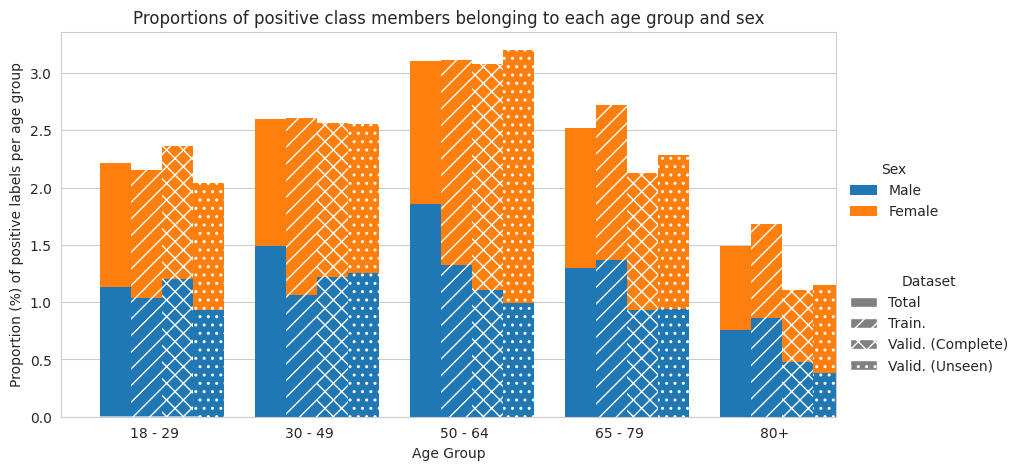

In [129]:
from transformer_experiment.utils.plots import plot_clustered_stacked

def demographics_barplot(save=None):
    fig, ax = plt.subplots(1,1, figsize=(10, 5))

    dfs = {}
    for dataset_name, df in DATASET_VARIANTS.items():
        df = df[['Female', 'Age', 'CriticalEvent']].copy()
        df['Female'] = df.Female.replace({True: "Female", False: "Male"})
        df['Age'] = SalfordData(df).derive_age_band(return_series=True)

        df = df.groupby(['Age', 'Female']).CriticalEvent.sum()/df.groupby(['Age']).CriticalEvent.count()*100
        df = df.reset_index().pivot(columns=['Female'], values=['CriticalEvent'], index='Age').CriticalEvent
        dfs[dataset_name] = df

    plot_clustered_stacked(list(dfs.values()), list(dfs.keys()), ['Sex', 'Dataset'], title='Proportions of positive class members belonging to each age group and sex')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Proportion (%) of positive labels per age group')
    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')


demographics_barplot(save=Notebook.IMAGE_DIR/'age_sex_bars.svg')

### Inclusion-Exclusion

In [22]:
def inclusion_exclusion_flow():
    df = pd.read_hdf(Notebook.DATA_DIR/'raw_v2.h5', 'table')
    df = SalfordData.from_raw(df, verbose=True)
    df = df.inclusion_exclusion_criteria(verbose=True)
    
inclusion_exclusion_flow()

Initial dataset size: 401650
Removed 2 patients without a valid NHS number or age: 401648
Removed 193 patients not discharged yet: 401455
Removed 35628 cases before Jan 1st 2015: 365827
Removed 1 records under 18 years old: 365826
Removed 71812 booked admissions, elective admissions, maternity, and trauma cases: 294014
Removed 72734 records without, at minimum, recorded NEWS: 221280
Removed 98013 records to limit cases to acute medical admissions: 123267
